In [ ]:
!python -m pip install spacy==2.3.2 -q
!python -m spacy download pl_core_news_md
!python -m spacy download en_core_web_md

In [42]:
import re
import numpy as np
import pandas as pd
import string

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import spacy

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

#Ładowanie i preprocessing danych

Wykorzystany zbiór: https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset?resource=download

In [2]:
DATASET_COLUMNS=['sentiment','message','tweetid']
df = pd.read_csv('twitter_sentiment_data.csv', names=DATASET_COLUMNS)[1:]
df.head()

,sentiment,message,tweetid
1,-1,@tiniebeany climate change is an interesting h...,792927353886371840
2,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
3,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
4,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [3]:
# sentyment -1 - negatywny, 0 - neutralny, 1 - pozytywny, 2 - news o zmianie klimatu (bez sentymentu)
df['sentiment'] = pd.to_numeric(df['sentiment'])
df = df[df['sentiment'] != 2] # usunięcie newsów
df = df[df['sentiment'] != 0] # usunięcie neutralnych
len(df)

26952

In [4]:
data = df[['sentiment', 'message']]
data['sentiment'] = data['sentiment'].replace(-1, 0)
data['sentiment'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([0, 1])

In [5]:
nlp = spacy.load('en_core_web_md')
stop_words = nlp.Defaults.stop_words

In [6]:
def text_preprocessing(text):
  # text = str(text)
  text = text.lower()
  text = " ".join([word for word in text.split() if word not in stop_words])
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  text = re.sub(r'(.)1+', r'1', text) # powtarzające się znaki
  text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text) # adresy url
  text = re.sub('[0-9]+', '', text)
  if text.startswith('rt '): # usunięcie oznaczenia retweet'u
    text = text[3:]
  return text

In [7]:
data['message'] = data['message'].apply(text_preprocessing)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
data.head()

,sentiment,message
1,0,tiniebeany climate change interesting hustle g...
2,1,natgeochannel watch beforetheflood right here ...
3,1,fabulous leonardo dicaprios film climate chang...
4,1,mickfanning watched amazing documentary leonar...
10,1,beforetheflood watch beforetheflood right here...


In [9]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
data['message'] = data['message'].apply(tokenizer.tokenize)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentiment,message
1,0,"[tiniebeany, climate, change, interesting, hus..."
2,1,"[natgeochannel, watch, beforetheflood, right, ..."
3,1,"[fabulous, leonardo, dicaprios, film, climate,..."
4,1,"[mickfanning, watched, amazing, documentary, l..."
10,1,"[beforetheflood, watch, beforetheflood, right,..."


In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
lemmatizer = nltk.WordNetLemmatizer()
data['message'] = data['message'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentiment,message
1,0,"[tiniebeany, climate, change, interesting, hus..."
2,1,"[natgeochannel, watch, beforetheflood, right, ..."
3,1,"[fabulous, leonardo, dicaprios, film, climate,..."
4,1,"[mickfanning, watched, amazing, documentary, l..."
10,1,"[beforetheflood, watch, beforetheflood, right,..."


In [30]:
X = data.message.astype(str)
y = data.sentiment.astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
X_train.head()

28893    ['ajplus', 'activist', 'sealed', 'letter', 'ti...
24986    ['issascottie', 'trump', 'president', 'north',...
2189     ['berniesanders', 'the', 'concept', 'global', ...
23694    ['week', 'new', 'scientist', 'focus', 'climate...
16362    ['fightnowamerica', 'blind', 'liberal', 'cant'...
Name: message, dtype: object

In [33]:
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 500000)
vectorizer.fit(X_train)
print(f'Ilość słów po wektoryzacji: {len(vectorizer.get_feature_names())}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ilość słów po wektoryzacji: 185859


In [34]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

X_train

<24256x185859 sparse matrix of type '<class 'numpy.float64'>'
	with 520847 stored elements in Compressed Sparse Row format>

In [35]:
def evaluate_model(model):
  y_pred = model.predict(X_test)

  print(classification_report(y_test, y_pred))

  matrix = confusion_matrix(y_test, y_pred)

  categories = ['Negative','Positive']
  group_names = ['True Negative','False Positive', 'False Negative','True Positive']
  group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten() / np.sum(matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize = (10,10))
  sns.heatmap(matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [36]:
from sklearn.metrics import roc_curve, auc
def draw_roc_curve(y_test, y_pred):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE')
  plt.legend(loc="lower right")
  plt.show()

#Klasyczny ML

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       384
           1       0.86      1.00      0.93      2312

    accuracy                           0.86      2696
   macro avg       0.93      0.52      0.49      2696
weighted avg       0.88      0.86      0.80      2696



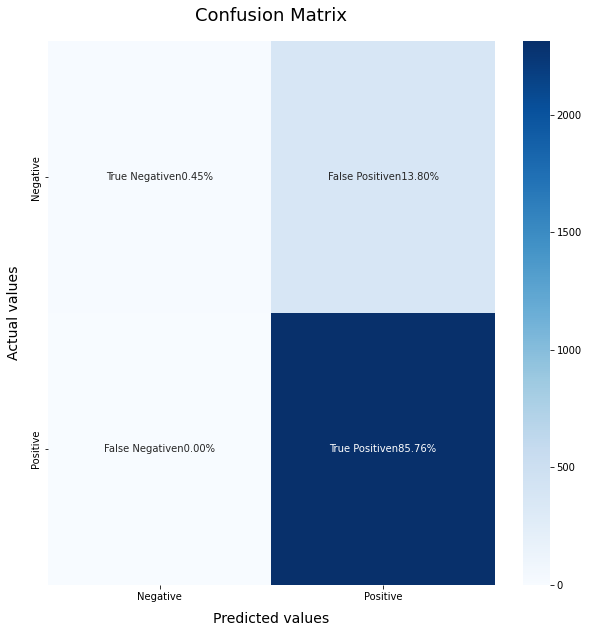

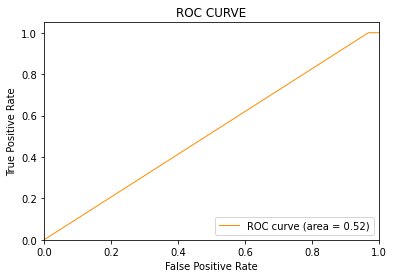

In [37]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
evaluate_model(BNBmodel)
y_pred = BNBmodel.predict(X_test)
draw_roc_curve(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.84      0.64      0.73       384
           1       0.94      0.98      0.96      2312

    accuracy                           0.93      2696
   macro avg       0.89      0.81      0.84      2696
weighted avg       0.93      0.93      0.93      2696



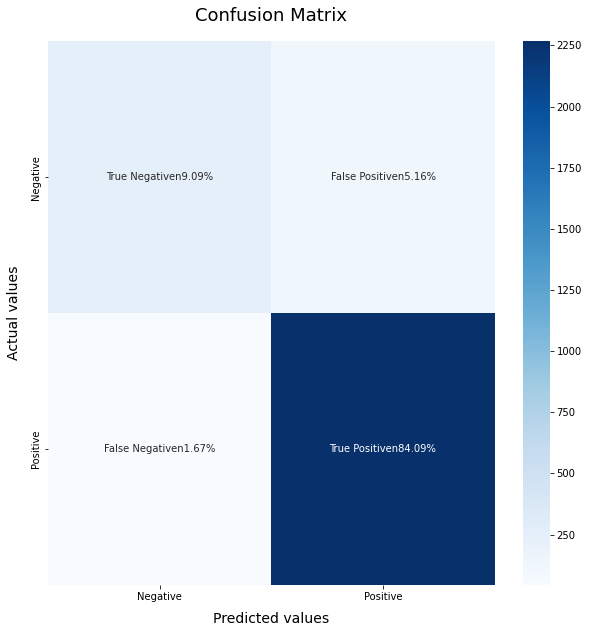

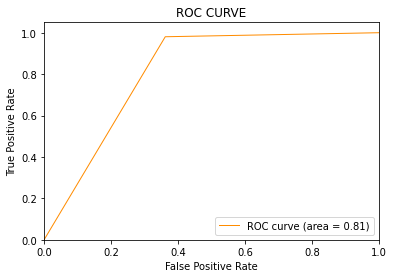

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
evaluate_model(SVCmodel)
y_pred = SVCmodel.predict(X_test)
draw_roc_curve(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.45      0.59       384
           1       0.92      0.99      0.95      2312

    accuracy                           0.91      2696
   macro avg       0.88      0.72      0.77      2696
weighted avg       0.91      0.91      0.90      2696



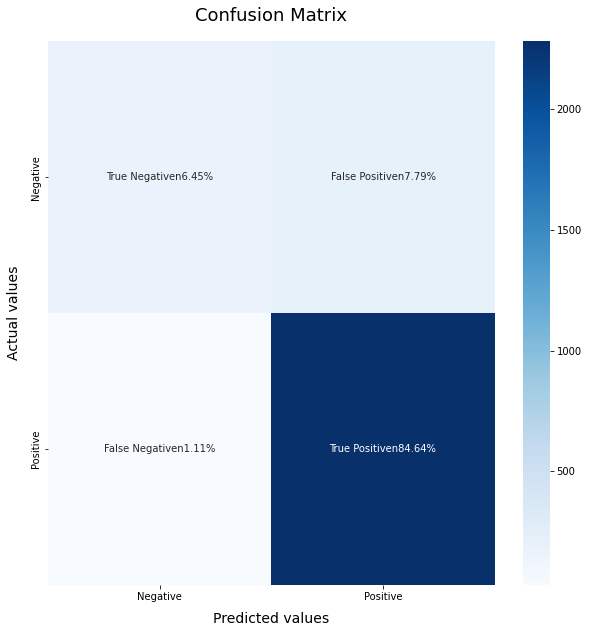

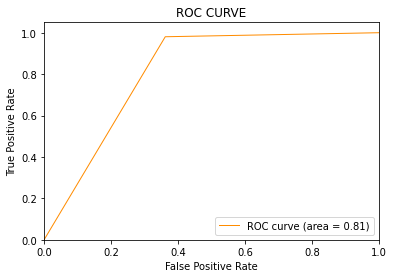

In [41]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
evaluate_model(LRmodel)
y_pred3 = LRmodel.predict(X_test)
draw_roc_curve(y_test, y_pred)

#Model NN

In [55]:
data = df[['sentiment', 'message']]
data['sentiment'] = data['sentiment'].replace(-1, 0)
data['sentiment'].unique()
data['message'] = data['message'].apply(text_preprocessing)
X = data.message.astype(str).to_numpy()
y = data.sentiment.astype(int).to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [57]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen = max_len)
print(padded_sequences)

[[   0    0    0 ...    4  181 2850]
 [   0    0    0 ...    2  244  182]
 [   0    0    0 ... 1582   57  547]
 ...
 [   0    0    0 ...    2   65 1632]
 [   0    0    0 ...    1    2 1853]
 [   0    0    0 ...  374 1176   53]]


In [59]:
labels = tf.keras.utils.to_categorical(y, 2, dtype = 'float32')
labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size = 0.1, random_state=42)

In [69]:
def train_model(epochs, lstm_neurons):
  model = Sequential()
  model.add(layers.Embedding(max_words, 40, input_length = max_len))
  model.add(layers.Bidirectional(layers.LSTM(lstm_neurons, dropout = 0.6)))
  model.add(layers.Dense(2, activation = 'softmax'))
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

  model.fit(X_train, y_train, epochs = epochs)

  loss, acc = model.evaluate(X_test, y_test)
  return model, loss, acc

In [72]:
epochs = [5, 10, 15]
lstm_neurons = [10, 20, 30]

best_loss = float('inf')
best_acc = 0
best_epochs = 0
best_neurons = 0

for epoch in epochs:
  for neurons in lstm_neurons:
    print(f'Sprawdzanie modelu: epoki - {epoch}, neurony - {neurons}')
    model, loss, acc = train_model(epoch, neurons)
    if loss < best_loss:
      best_loss = loss
      best_acc = acc
      best_epochs = epoch
      best_neurons = neurons
      model.save('best_model.h5', save_format='h5')

print(f'Najlepszy model:')
print(f'epoki: {best_epochs}')
print(f'ilość neuronów: {best_neurons}')
print(f'koszt: {best_loss}')
print(f'dokładność: {best_acc}')

Sprawdzanie modelu: epoki - 5, neurony - 10
Epoch 1/5
758/758 [==============================] - 71s 87ms/step - loss: 0.3469 - accuracy: 0.8639
Epoch 2/5
758/758 [==============================] - 66s 87ms/step - loss: 0.2672 - accuracy: 0.8972
Epoch 3/5
758/758 [==============================] - 66s 87ms/step - loss: 0.2397 - accuracy: 0.9100
Epoch 4/5
758/758 [==============================] - 66s 87ms/step - loss: 0.2288 - accuracy: 0.9147
Epoch 5/5
85/85 [==============================] - 3s 28ms/step - loss: 0.2333 - accuracy: 0.9147
Sprawdzanie modelu: epoki - 5, neurony - 20
Epoch 1/5
758/758 [==============================] - 71s 88ms/step - loss: 0.3499 - accuracy: 0.8627
Epoch 2/5
758/758 [==============================] - 67s 88ms/step - loss: 0.2718 - accuracy: 0.8949
Epoch 3/5
758/758 [==============================] - 67s 88ms/step - loss: 0.2419 - accuracy: 0.9100
Epoch 4/5
758/758 [==============================] - 67s 88ms/step - loss: 0.2310 - accuracy: 0.9149
Epoch 